In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

import csv
from datetime import datetime
from datetime import timedelta
#from struct import pack
import os
import gc
from numpy import abs, max 
import scipy
#from scipy import io
import numpy as np
from matplotlib import pyplot as plt
#from scipy.signal import butter, lfilter
from scipy import signal
#from scipy.signal import blackman
#from scipy.signal import periodogram
#import gc
#import os
import sys
import pandas as pd
#from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.spatial import distance

gc.enable()

video_start = '20190501'#'20190327'#'20181220' #YYYYMMDD
video_end = '20190501'#'20190327'#'20181220' #YYYYMMDD
data_path = '/data/'
sensor_list = ["acc_w","wifi"]#["gyro","acc2","acc_w","wifi","magnetic"]

temp_video_start = video_start[0:4] + "/" + video_start[4:6] + "/" +video_start[6:8]
temp_video_end = video_end[0:4] + "/" + video_end[4:6] + "/" +video_end[6:8]
print temp_video_start
print temp_video_end

video_startdatte = datetime.strptime(temp_video_start,'%Y/%m/%d')
video_enddate = datetime.strptime(temp_video_end,'%Y/%m/%d')

2019/05/01
2019/05/01


In [4]:
session_list = []
with open('capture_time.csv') as csvfile: #read session data from capture_time.csv
    readCSV = csv.reader(csvfile, delimiter='-')
    line_no = 0
    print "The data sessions taken during the start and end dates"
    for row in readCSV:
        if row[0] != '' and row[1] != '': #Check if both start and end times of each row exists
            starttime = datetime.strptime(row[0],'%Y/%m/%d %H:%M:%S.%f')
            endtime = datetime.strptime(row[1],'%Y/%m/%d %H:%M:%S.%f')
            #print starttime.date()
            if starttime.date() == video_startdatte.date() and endtime.date() == video_enddate.date(): #Check if sessions available which matches the startdate and enddate
                line_no = line_no + 1
                print "(", line_no, ")", "\t", starttime, "-", endtime, "\t", (endtime-starttime).seconds
                session_list.append(row[0] + "-" + row[1])

#print "Please input the session number. Confirm the start and end times using the video."
#session = raw_input("Session ") 
#print "You have chosen the session ", session

The data sessions taken during the start and end dates
( 1 ) 	2019-05-01 16:41:05.611000 - 2019-05-01 16:41:13.163000 	7
( 2 ) 	2019-05-01 16:42:40.785000 - 2019-05-01 16:43:10.407000 	29
( 3 ) 	2019-05-01 16:43:45.472000 - 2019-05-01 16:44:57.964000 	72
( 4 ) 	2019-05-01 16:54:00.370000 - 2019-05-01 16:54:34.154000 	33
( 5 ) 	2019-05-01 17:09:03.935000 - 2019-05-01 17:13:19.206000 	255
( 6 ) 	2019-05-01 17:34:35.146000 - 2019-05-01 17:38:39.256000 	244
( 7 ) 	2019-05-01 17:54:56.137000 - 2019-05-01 17:58:14.905000 	198
( 8 ) 	2019-05-01 17:59:27.842000 - 2019-05-01 18:03:30.776000 	242
( 9 ) 	2019-05-01 18:32:31.120000 - 2019-05-01 18:36:21.541000 	230
( 10 ) 	2019-05-01 18:45:58.958000 - 2019-05-01 18:49:56.742000 	237


In [49]:
sessions = raw_input("Session ")

Session 5,6,8,9,10


In [51]:
sessions = map(int, sessions.split(","))

In [52]:
sessions.sort()

In [53]:
sessions

[5, 6, 8, 9, 10]

In [54]:
session_starttime = datetime.strptime(session_list[int(sessions[0])-1][0:23],'%Y/%m/%d %H:%M:%S.%f')

In [55]:
session_endtime = datetime.strptime(session_list[int(sessions[-1])-1][24:47],'%Y/%m/%d %H:%M:%S.%f')

In [56]:
print "Start and end times for your selected session are as follows."
print "Start time = ",session_starttime
print "End time = ",session_endtime

Start and end times for your selected session are as follows.
Start time =  2019-05-01 17:09:03.935000
End time =  2019-05-01 18:49:56.742000


In [67]:
start_end_list = []

for session in sessions:
    start_end_list.append([datetime.strptime(session_list[int(session)-1][0:23],'%Y/%m/%d %H:%M:%S.%f'),datetime.strptime(session_list[int(session)-1][24:47],'%Y/%m/%d %H:%M:%S.%f')])

In [68]:
start_end_list

[[datetime.datetime(2019, 5, 1, 17, 9, 3, 935000),
  datetime.datetime(2019, 5, 1, 17, 13, 19, 206000)],
 [datetime.datetime(2019, 5, 1, 17, 34, 35, 146000),
  datetime.datetime(2019, 5, 1, 17, 38, 39, 256000)],
 [datetime.datetime(2019, 5, 1, 17, 59, 27, 842000),
  datetime.datetime(2019, 5, 1, 18, 3, 30, 776000)],
 [datetime.datetime(2019, 5, 1, 18, 32, 31, 120000),
  datetime.datetime(2019, 5, 1, 18, 36, 21, 541000)],
 [datetime.datetime(2019, 5, 1, 18, 45, 58, 958000),
  datetime.datetime(2019, 5, 1, 18, 49, 56, 742000)]]

In [191]:
if not os.path.exists("/env"):
    os.makedirs("/env",0777)

In [190]:
for ses in sessions:
    #if not os.path.exists("/env/" + str(ses)):
    #os.rmdir("/env/" + str(ses))
    os.makedirs("/env/" + str(ses),0777)

In [57]:
df_acc2 = pd.DataFrame()
df_acc_w = pd.DataFrame()
df_gyro = pd.DataFrame()
df_magnetic = pd.DataFrame()
results = []


for sensor in sensor_list:
    df = pd.DataFrame()
    for data_filename in os.listdir("data/" + sensor + "/" + video_start): #read data files from data folder
        data_filename = os.path.splitext(data_filename)[0]
        #print datetime.strptime(session_starttime.strftime('%Y/%m/%d %H:%M:%S.%f')[:19],'%Y/%m/%d %H:%M:%S')


        data_filename_datetime = datetime.strptime(data_filename[0:15],'%Y%m%d_%H%M%S')
        #print data_filename_datetime
        if data_filename_datetime >= datetime.strptime(session_starttime.strftime('%Y/%m/%d %H:%M:%S.%f')[:19],'%Y/%m/%d %H:%M:%S') and data_filename_datetime <= datetime.strptime(session_endtime.strftime('%Y/%m/%d %H:%M:%S.%f')[:19],'%Y/%m/%d %H:%M:%S'): #check if the file is in the selected session
            #samplerate, data = wavfile.read(stereo_path + wav_filename +'.wav')
            print "Reading file", data_filename
            if sensor!="wifi":
                df_temp = pd.read_csv("data/" + sensor + "/" + video_start + "/" + data_filename + ".csv")
                #df.index = df['time']
                df_temp.set_index('time', inplace = True)
                #display(df_temp.head())
                df = df.append(df_temp, ignore_index=False)

            if sensor=="wifi":
                with open("data/" + sensor + "/" + video_start + "/" + data_filename + ".csv") as csvfile:
                    spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
                    for row in spamreader:
                        results.append(row)


    if sensor=="acc2":
        df_acc2=df
    if sensor=="acc_w":
        df_acc_w=df
    if sensor=="gyro":
        df_gyro=df
    if sensor=="magnetic":
        df_magnetic=df
    if sensor=="wifi":
        df_wifi=df

#df_acc2 = df_acc2.sort_values(by='time')
#df_acc_w = df_acc_w.sort_values(by='time')
#df_gyro = df_gyro.sort_values(by='time')
#df_magnetic = df_magnetic.sort_values(by='time')

df_acc2.sort_index(inplace=True)
df_acc_w.sort_index(inplace=True)
df_gyro.sort_index(inplace=True)
df_magnetic.sort_index(inplace=True)
#df_wifi = df_wifi.sort_values(by='time')
print "All the data files have been read, appended an sorted according to the time stamps"

Reading file 20190501_183500_acc_w
Reading file 20190501_170930_acc_w
Reading file 20190501_175700_acc_w
Reading file 20190501_173630_acc_w
Reading file 20190501_180130_acc_w
Reading file 20190501_171200_acc_w
Reading file 20190501_184730_acc_w
Reading file 20190501_183330_acc_w
Reading file 20190501_171130_acc_w
Reading file 20190501_184630_acc_w
Reading file 20190501_184930_acc_w
Reading file 20190501_183600_acc_w
Reading file 20190501_183400_acc_w
Reading file 20190501_175430_acc_w
Reading file 20190501_175600_acc_w
Reading file 20190501_175530_acc_w
Reading file 20190501_171000_acc_w
Reading file 20190501_180330_acc_w
Reading file 20190501_183530_acc_w
Reading file 20190501_184900_acc_w
Reading file 20190501_171030_acc_w
Reading file 20190501_183300_acc_w
Reading file 20190501_180100_acc_w
Reading file 20190501_175900_acc_w
Reading file 20190501_173830_acc_w
Reading file 20190501_173600_acc_w
Reading file 20190501_180200_acc_w
Reading file 20190501_173800_acc_w
Reading file 2019050

In [59]:
len(df_acc_w)

137972

In [72]:
df_acc_w.head()

,x,y,z
time,,,
20190501_17:09:30.002,-6.151932,13.094650,1.423096
20190501_17:09:30.012,-6.264893,11.719070,1.199951
20190501_17:09:30.022,-5.984146,10.910080,1.254120
20190501_17:09:30.032,-5.659958,10.463760,1.623474
20190501_17:09:30.042,-5.387619,10.331375,2.081268


# Acceleration PCA calculation

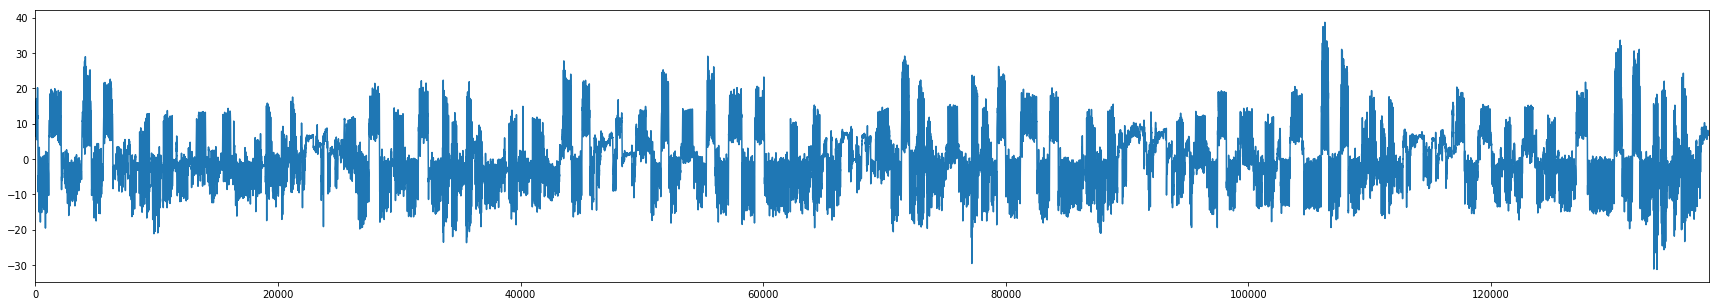

In [62]:
acc2 = np.array(df_acc_w)

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
acc = pca.fit_transform(acc2)
plt.figure(figsize=(30,5))
plt.xlim(0,len(acc))
plt.plot(acc)
plt.show()

In [141]:
df_acc_pca =pd.DataFrame(acc, index = df_acc_w.index)

In [160]:
df_acc_pca.index[0]

'20190501_17:09:30.002'

In [165]:
df_acc_pca.index = pd.to_datetime(df_acc_pca.index,format = '%Y%m%d_%H:%M:%S.%f')

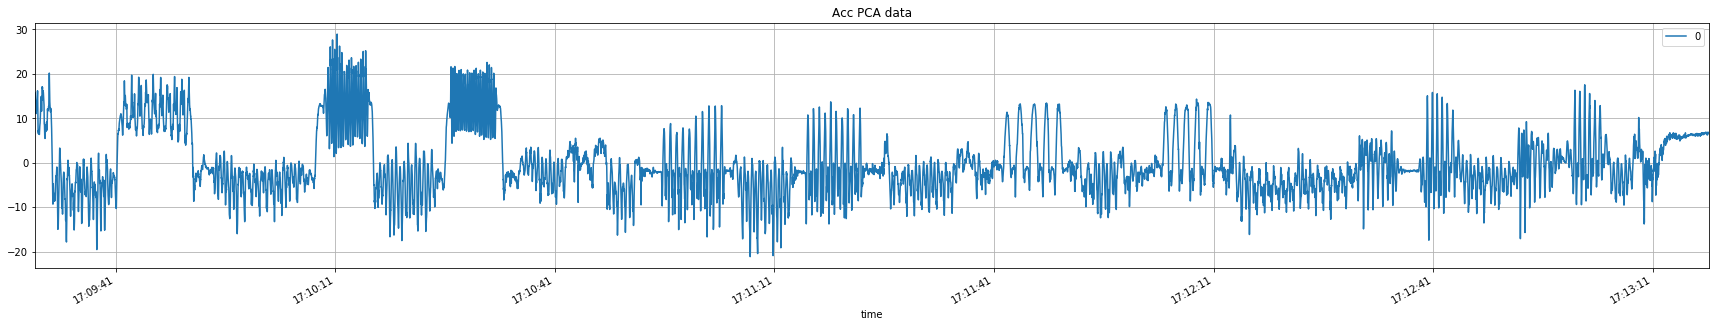

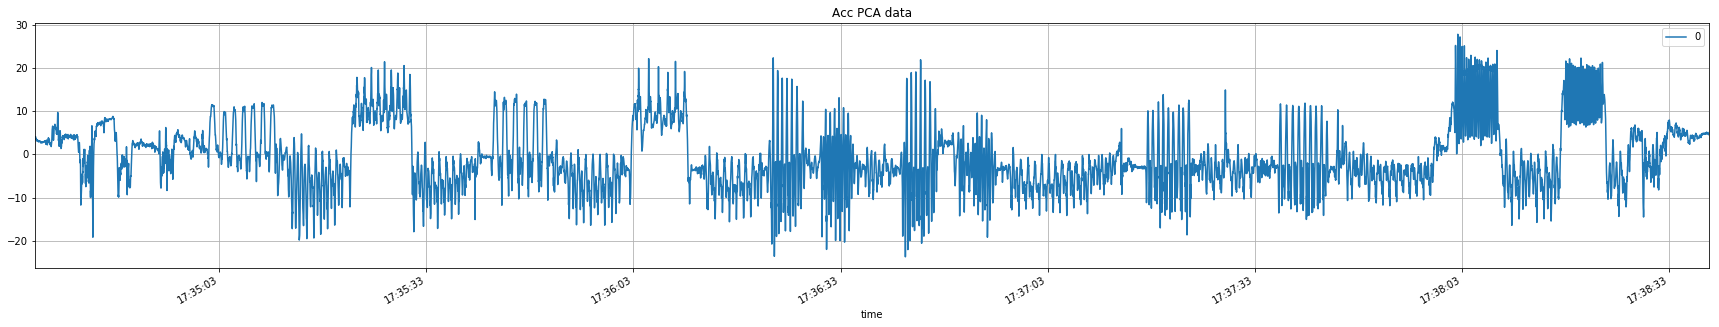

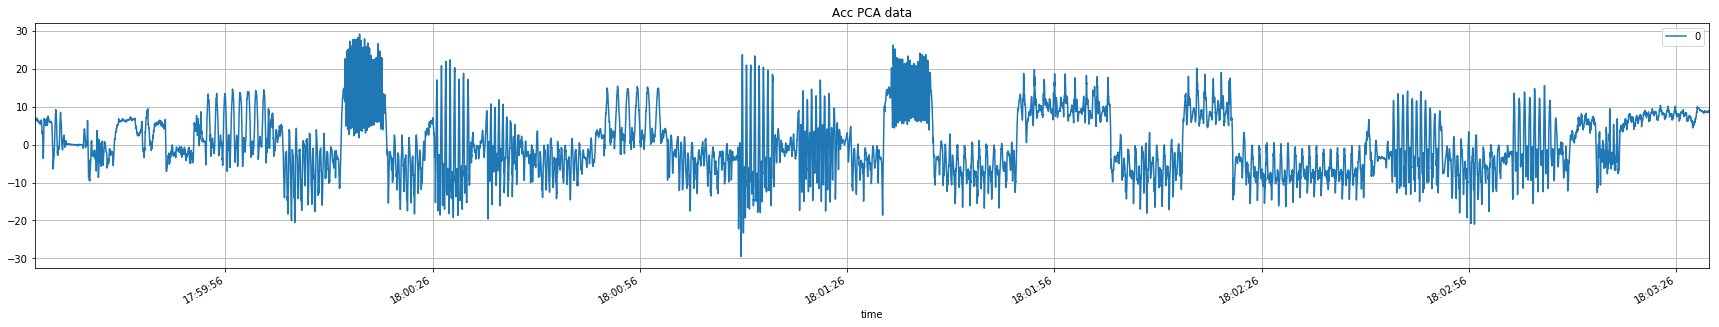

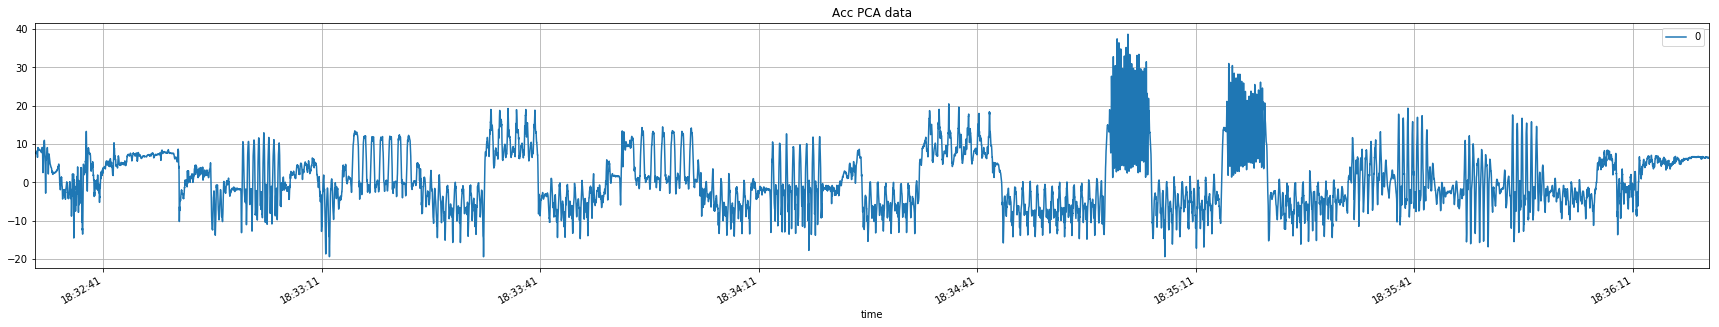

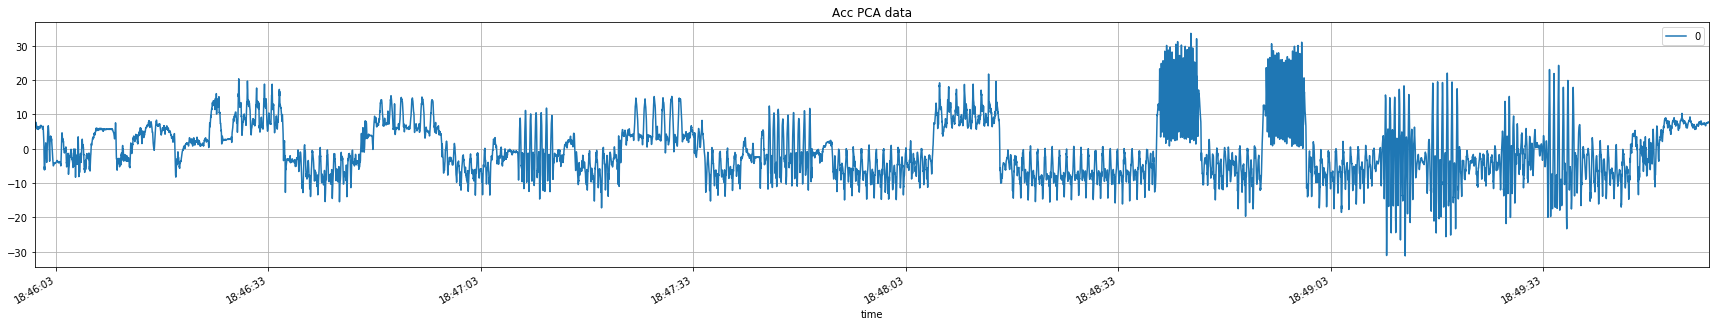

In [207]:
ses_num = 0
for ses in start_end_list:
    df2 = df_acc_pca.loc[ses[0]:ses[1]]
    df2.to_csv("env/" + str(sessions[ses_num]) + "/" + "acc_pca")
    df2.plot(figsize = (30,5),title="Acc PCA data",grid=1)
    plt.savefig("env/" + str(sessions[ses_num]) + "/" + "acc_fig")
    plt.show()
    ses_num = ses_num + 1

In [ ]:
df2